## Test-bed notebook to find taxonomic groupings for pheromoneFinder
### Authored by Sri Srikant, Murray and Gaudet Labs, Harvard
Modified to run on my sager since my xps15 died, installed the following packages with potential for version issues.
1. biopython 1.78
2. dendropy 4.5.1

[210718] Triumphant return to my xps15, but I am going to modify all the data folders to point to the Google Drive folder in my Windows installation.

In [7]:
##This is to test code snippets for the pheromoneFinder codebase
import sys
import os
from os import listdir
from os.path import isfile, join

import traceback
import re

from Bio import SeqIO
from Bio.Seq import Seq
##from Bio.Alphabet import IUPAC ##deprecated in biopython 1.78
from collections import defaultdict
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
import xml.etree.ElementTree as ET

import dendropy
import numpy as np
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt

import csv
import math
import operator
from operator import attrgetter
from pprint import pprint

data_dir = os.path.join("/home", "ssrikant", "WindowsFiles", "Fungi_pheromoneFinder", "Cluster")
figure_dir = os.path.join(data_dir, "figures")

#Setting matplotlib to be inline
%matplotlib inline

In [8]:
tree_dir = os.path.join(data_dir, "tree")

In [9]:
#Printing file list
fileList = [f for f in os.listdir(tree_dir) if os.path.isfile(os.path.join(tree_dir, f))]
print("List of files:")
print("\n".join(fileList))

List of files:
332genomes_Shen2017.csv
332genomes_Shen2017.xlsx
332taxa_index.txt
332_2408OGs_timetree_mcmctree.nwk
332_2408OGs_timetree_reltime.nwk
taxonGroups.csv
taxonGroups_180max-dist_mating-regulation.csv
taxonGroups_240max-dist.csv


In [10]:
##Importing Newick phylogenetic trees
phyloTree = dendropy.Tree.get(file=open(os.path.join(tree_dir, "332_2408OGs_timetree_reltime.nwk"), 'r'), schema="newick")

### Code blocks below are to calculate and plot the pair-wise distances of species
These are using the dendropy.<i>Tree</i>.pdc(), to read in the Newick reltime tree from the Shen XX, Cell (2018) paper to identify clades of species that have diverged within a time horizon.
> Written originally in Windows and moved to WSL Ubuntu 18.04 for further work and testing to move to Odyssey.

yHMPu5000041678 Debaryomyces prosopidis 	 yHMPu5000034742 Lipomyces suomiensis 
 904.3625675999999
110224


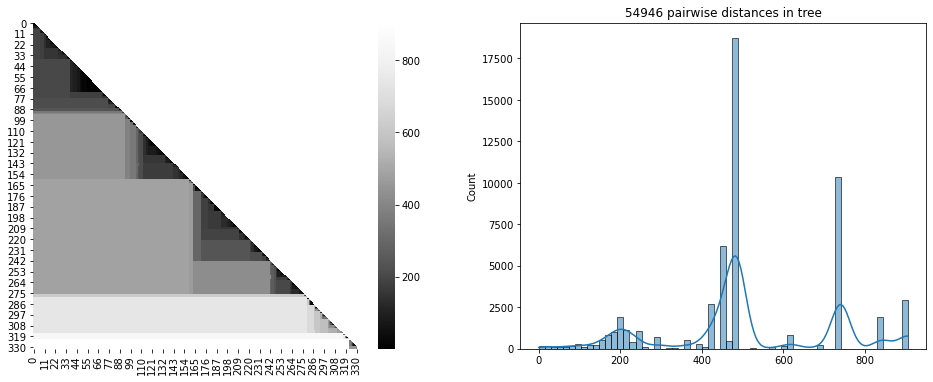

In [12]:
distMatrix = np.zeros((len(phyloTree.taxon_namespace), len(phyloTree.taxon_namespace)))
pdc = phyloTree.phylogenetic_distance_matrix()
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        #print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
        distMatrix[i,j] = pdc(t1, t2);
#print(distMatrix)
print(phyloTree.taxon_namespace[0].label, "\t", phyloTree.taxon_namespace[-1].label, "\n", 
      pdc.distance(phyloTree.taxon_namespace[0], phyloTree.taxon_namespace[-1]))
print(len(distMatrix.flatten()))
mask = np.zeros_like(distMatrix, dtype=bool) #np.bool deprecated with identical implementation as bool
mask[np.triu_indices_from(mask)] = True
#print(pdc.distance(phyloTree.taxon_namespace[:], phyloTree.taxon_namespace[:]))
fig1 = figure(figsize=(16,6))
ax1 = subplot(121)
#ax = sns.heatmap(distMatrix[0:99, 0:99], yticklabels=phyloTree.taxon_namespace[0:99])
ax1 = sns.heatmap(distMatrix, mask=mask, cmap="Greys_r")

ax2 = subplot(122)
plot = list(filter(lambda a: a != 0, distMatrix.flatten()))
ax2 = sns.histplot(plot, kde=True)
##ax2 = sns.distplot(plot, kde=True, rug=True) ##distplot is being deprecated and replacing with axis-level histplot
pairwise_dist_title = " ".join([str(len(plot)), "pairwise distances in tree"])
plt.title(pairwise_dist_title);
#savefig(os.path.join(figure_dir, "Shen_332yeast_pairwise-dist_reltime.pdf"), dpi=300, transparent=True)

#### Code-base to identify the time-horizon for the conservation of a-factor-like (lipidated) fungal pheromones
I am going to assume that the "conservation" here corresponds to pheromones that can be recognized from one species to another. The best examples I have are S. cerevisiae and K. lactis, within the Saccharomycetaceae and the 5 species in the Yarrowia clade.

In [13]:
##Identifying the evolutionary time horizon for the divergence of all species in the Yarrowia clade.
yarrowiaPair = []
yarrowiaDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("Yarrowia" in t1.label) and ("Yarrowia" in t2.label)) or (("Yarrowia" in t2.label) and ("Yarrowia" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            yarrowiaPair.append([t1.label, t2.label])
            yarrowiaDist.append(pdc(t1, t2))
index, value = max(enumerate(yarrowiaDist), key=operator.itemgetter(1))
print("Max. divergence time of Yarrowia is between: ", yarrowiaPair[index], "\t of time: ", yarrowiaDist[index])
print(max(yarrowiaDist))

Distance between 'Yarrowia keelungensis' and 'yHMPu5000035643 Yarrowia bubula': 46.3610224
Distance between 'Yarrowia lipolytica' and 'yHMPu5000035643 Yarrowia bubula': 46.3610223
Distance between 'Yarrowia lipolytica' and 'Yarrowia keelungensis': 26.3931419
Distance between 'Yarrowia deformans' and 'yHMPu5000035643 Yarrowia bubula': 46.3610224
Distance between 'Yarrowia deformans' and 'Yarrowia keelungensis': 26.393141999999997
Distance between 'Yarrowia deformans' and 'Yarrowia lipolytica': 20.5187099
Distance between 'yHMPu5000035645 Yarrowia divulgata' and 'yHMPu5000035643 Yarrowia bubula': 46.3610224
Distance between 'yHMPu5000035645 Yarrowia divulgata' and 'Yarrowia keelungensis': 26.393141999999997
Distance between 'yHMPu5000035645 Yarrowia divulgata' and 'Yarrowia lipolytica': 20.5187099
Distance between 'yHMPu5000035645 Yarrowia divulgata' and 'Yarrowia deformans': 6.2020266
Max. divergence time of Yarrowia is between:  ['Yarrowia keelungensis', 'yHMPu5000035643 Yarrowia bubul

In [14]:
##Identifying the evolutionary divergence time between the Saccharomycetaceae (K. lactis) and Saccharomycodaceae (Hanseniaspora)
speciesPair = []
speciesDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("lactis" in t1.label) and ("Hanseniaspora" in t2.label)) or (("lactis" in t2.label) and ("Hanseniaspora" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            speciesPair.append([t1.label, t2.label])
            speciesDist.append(pdc(t1, t2))
index, value = max(enumerate(speciesDist), key=operator.itemgetter(1))
print("Max. divergence time of Saccharomyces MFA1/2-like is between: ", speciesPair[index], "\t of time: ", speciesDist[index])
print(max(speciesDist))

Distance between 'Kluyveromyces lactis' and 'Hanseniaspora vinae': 295.48907810000003
Distance between 'Kluyveromyces lactis' and 'yHMPu5000034957 Hanseniaspora osmophila': 295.48907810000003
Distance between 'Kluyveromyces lactis' and 'yHMPu5000035695 Hanseniaspora pseudoguilliermondii': 295.489078
Distance between 'Kluyveromyces lactis' and 'yHMPu5000034963 Hanseniaspora clermontiae': 295.489078
Distance between 'Kluyveromyces lactis' and 'Hanseniaspora uvarum': 295.489078
Distance between 'Kluyveromyces lactis' and 'Hanseniaspora valbyensis': 295.48907810000003
Distance between 'Kluyveromyces lactis' and 'yHMPu5000035696 Hanseniaspora singularis': 295.48907810000003
Max. divergence time of Saccharomyces MFA1/2-like is between:  ['Kluyveromyces lactis', 'Hanseniaspora vinae'] 	 of time:  295.48907810000003
295.48907810000003


In [15]:
##Identifying the evolutionary time horizon for the divergence of all species in the Saccharomycetaceae clade (tested as between S. cerevisiae and K. lactis).
speciesPair = []
speciesDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("cere" in t1.label) and ("lactis" in t2.label)) or (("cere" in t2.label) and ("lactis" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            speciesPair.append([t1.label, t2.label])
            speciesDist.append(pdc(t1, t2))
index, value = max(enumerate(speciesDist), key=operator.itemgetter(1))
print("Max. divergence time of Saccharomyces MFA1/2-like is between: ", speciesPair[index], "\t of time: ", speciesDist[index])
print(max(speciesDist))

Distance between 'Kluyveromyces lactis' and 'Saccharomyces cerevisiae': 237.6215988
Max. divergence time of Saccharomyces MFA1/2-like is between:  ['Kluyveromyces lactis', 'Saccharomyces cerevisiae'] 	 of time:  237.6215988
237.6215988


In [16]:
##Identifying the distance of closest neighbor to the Yarrowia lineage. As seen it is already more than the value expected to share pheromones; though the divergence time 
##is not a hard limit that arises naturally.
speciesPair = []
speciesDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("Nadsonia" in t1.label) and ("Yarrowia" in t2.label)) or (("Nadsonia" in t2.label) and ("Yarrowia" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            speciesPair.append([t1.label, t2.label])
            speciesDist.append(pdc(t1, t2))
index, value = max(enumerate(speciesDist), key=operator.itemgetter(1))
print("Max. divergence time of: ", speciesPair[index], "\t of time: ", speciesDist[index])
print(max(speciesDist))

Distance between 'yHMPu5000035643 Yarrowia bubula' and 'yHMPu5000034635 Nadsonia fulvescens': 611.5004867
Distance between 'yHMPu5000035643 Yarrowia bubula' and 'Nadsonia fulvescens var elongata': 611.5004867
Distance between 'Yarrowia keelungensis' and 'yHMPu5000034635 Nadsonia fulvescens': 611.5004867
Distance between 'Yarrowia keelungensis' and 'Nadsonia fulvescens var elongata': 611.5004867
Distance between 'Yarrowia lipolytica' and 'yHMPu5000034635 Nadsonia fulvescens': 611.5004865999999
Distance between 'Yarrowia lipolytica' and 'Nadsonia fulvescens var elongata': 611.5004865999999
Distance between 'Yarrowia deformans' and 'yHMPu5000034635 Nadsonia fulvescens': 611.5004867
Distance between 'Yarrowia deformans' and 'Nadsonia fulvescens var elongata': 611.5004867
Distance between 'yHMPu5000035645 Yarrowia divulgata' and 'yHMPu5000034635 Nadsonia fulvescens': 611.5004867
Distance between 'yHMPu5000035645 Yarrowia divulgata' and 'Nadsonia fulvescens var elongata': 611.5004867
Max. di

#### Code-block to identify the time-horizon for the conservation of the regulation of mating genes.
This is to identify the time-horizon of evolutionary conservation of the regulation of mating genes. The Sorrells TR, Nature (2015) [doi: 10.1038/nature14613] paper inspired the basis of looking for an evolutionary relationship to the motifs for mating regulatory TFs, specifically STE12 in the Saccharomyces clade.

In [17]:
##Identifying the evolutionary time horizon for the divergence of all species in the Saccharomycetaceae clade (tested as between S. cerevisiae and K. lactis).
speciesPair = []
speciesDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("cerevisiae" in t1.label) and ("polyspora" in t2.label)) or (("cerevisiae" in t2.label) and ("polyspora" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            speciesPair.append([t1.label, t2.label])
            speciesDist.append(pdc(t1, t2))
index, value = max(enumerate(speciesDist), key=operator.itemgetter(1))
print("Max. divergence time of first clade (Saccharomyces) described in Sorrells et al is between: ", speciesPair[index], "\t of time: ", speciesDist[index])
print(max(speciesDist))

Distance between 'Saccharomyces cerevisiae' and 'Vanderwaltozyma polyspora': 181.2832848
Max. divergence time of first clade (Saccharomyces) described in Sorrells et al is between:  ['Saccharomyces cerevisiae', 'Vanderwaltozyma polyspora'] 	 of time:  181.2832848
181.2832848


In [18]:
##Identifying the evolutionary time horizon for the divergence of all species in the Saccharomycetaceae clade (tested as between S. cerevisiae and K. lactis).
speciesPair = []
speciesDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("kluyveri" in t1.label) and ("lactis" in t2.label)) or (("kluyveri" in t2.label) and ("lactis" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            speciesPair.append([t1.label, t2.label])
            speciesDist.append(pdc(t1, t2))
index, value = max(enumerate(speciesDist), key=operator.itemgetter(1))
print("Max. divergence time of second clade (Kluyveromyces) described in Sorrells et al is between: ", speciesPair[index], "\t of time: ", speciesDist[index])
print(max(speciesDist))

Distance between 'Kluyveromyces lactis' and 'Lachancea kluyveri': 214.5338346
Max. divergence time of second clade (Kluyveromyces) described in Sorrells et al is between:  ['Kluyveromyces lactis', 'Lachancea kluyveri'] 	 of time:  214.5338346
214.5338346


In [19]:
##Identifying the evolutionary time horizon for the divergence of all species in the Saccharomycetaceae clade (tested as between S. cerevisiae and K. lactis).
speciesPair = []
speciesDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("bicuspidata" in t1.label) and ("guilliermondii" in t2.label)) or (("bicuspidata" in t2.label) and ("guilliermondii" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            speciesPair.append([t1.label, t2.label])
            speciesDist.append(pdc(t1, t2))
index, value = max(enumerate(speciesDist), key=operator.itemgetter(1))
print("Max. divergence time of third clade (Candida) described in Sorrells et al is between: ", speciesPair[index], "\t of time: ", speciesDist[index])
print(max(speciesDist))

Distance between 'Meyerozyma guilliermondii' and 'Metschnikowia bicuspidata': 213.7973007
Distance between 'yHMPu5000035695 Hanseniaspora pseudoguilliermondii' and 'Metschnikowia bicuspidata': 486.48659929999997
Max. divergence time of third clade (Candida) described in Sorrells et al is between:  ['yHMPu5000035695 Hanseniaspora pseudoguilliermondii', 'Metschnikowia bicuspidata'] 	 of time:  486.48659929999997
486.48659929999997


In [20]:
##Identifying the evolutionary time horizon for the divergence of all species in the Saccharomycetaceae clade (tested as between S. cerevisiae and K. lactis).
###This doesn't seem like the right pair. I am going to ignore this for now.
speciesPair = []
speciesDist = []
for i, t1 in enumerate(phyloTree.taxon_namespace):
    for j, t2 in enumerate(phyloTree.taxon_namespace[:i]):
        if ((("polymorpha" in t1.label) and ("tannophilus" in t2.label)) or (("polymorpha" in t2.label) and ("tannophilus" in t1.label))):
            print("Distance between '%s' and '%s': %s" % (t1.label, t2.label, pdc(t1, t2)))
            speciesPair.append([t1.label, t2.label])
            speciesDist.append(pdc(t1, t2))
index, value = max(enumerate(speciesDist), key=operator.itemgetter(1))
print("Max. divergence time of fourth clade (Pichia) described in Sorrells et al is between: ", speciesPair[index], "\t of time: ", speciesDist[index])
print(max(speciesDist))

Distance between 'Ogataea parapolymorpha' and 'Pachysolen tannophilus': 386.6871759
Distance between 'Ogataea polymorpha' and 'Pachysolen tannophilus': 386.6871759
Max. divergence time of fourth clade (Pichia) described in Sorrells et al is between:  ['Ogataea parapolymorpha', 'Pachysolen tannophilus'] 	 of time:  386.6871759
386.6871759


----
Inferences from the runs above:
1. From the 4 clades, it seems like a good time horizon of conservation of mating gene motifs are 180, since I am hoping for a conservative estimate, i.e. the horizon that gives me maximum confidence of shared motifs.  
2. This is also consistent with the fact that the only time-horizon of STE12 motif conserved in a-specific gene promoters is for the clade of Saccharomyces.
3. Another possible thought is to restrict this search within the major clades that I have. But would this work?
----
----

### First-pass taxonomic grouping based on the divergence times
Let us assume that the list of taxons are ordered such that neighbors in the list are the closest and we can therefore limit are check of relatedness to the immediate neighbor and only move on once we classify as within the group or out of the group.  
> I'm not sure if this is true for an arbitrary tree. I am going to think about how to generalize based on just slicing lists based on the distance measures. I can move down a list of taxon_names and then remove members that are within a particular divergence time.
> 
> {191026/1628hrs} I've managed to code a more generalized classifier 3 cells down.

Also it is worth considering that the divergenceLimit that is appropriate is that which separates the Saccharomyces cerevisiae and Kluyveromyces lactis species on the tree since the pheromones can be found by sequence homology. Need to confirm this by tBLASTN.

212
23


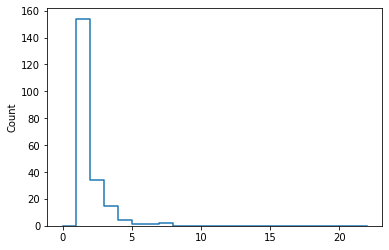

In [23]:
##Trying to build groupings of strains that are within a known value of divergence time.
##I am going to round up from the value estimated in the yarrowia group.
divergenceLimit = 50.0;
taxoGroups = [[phyloTree.taxon_namespace[0].label]]
for i, t1 in enumerate(phyloTree.taxon_namespace[:-2]):
    #print(i)
    if pdc(t1, phyloTree.taxon_namespace[i+1]) <= divergenceLimit:
        taxoGroups[-1].append(phyloTree.taxon_namespace[i+1].label)
    else:
        taxoGroups.append([phyloTree.taxon_namespace[i+1].label])
print(len(taxoGroups))

##Hist of group sizes
groupSize = []
for taxoGroup in taxoGroups:
    groupSize.append(len(taxoGroup))
binList = list(range(max(groupSize)))
print(max(groupSize))
ax1 = sns.histplot(groupSize, kde=False, bins=binList, stat='count', element='step', fill=False);
##ax1 = sns.distplot(groupSize, kde=False, bins=binList, hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1});
#plt.ylim(0, 50)
#ax2 = sns.swarmplot(groupSize);

# with open(os.path.join(tree_dir, "taxonGroups.csv"), 'w') as writeFile:
#     writer = csv.writer(writeFile)
#     writer.writerows(taxoGroups)

143


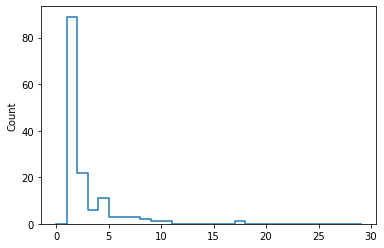

In [24]:
##Trying to build groupings of strains that are within a known value of divergence time.
##I am going to be as loose about including more species by doubling the divergence time from the yarrowia group (above).
divergenceLimit = 100.0;
taxoGroups = [[phyloTree.taxon_namespace[0].label]]
for i, t1 in enumerate(phyloTree.taxon_namespace[:-2]):
    #print(i)
    if pdc(t1, phyloTree.taxon_namespace[i+1]) <= divergenceLimit:
        taxoGroups[-1].append(phyloTree.taxon_namespace[i+1].label)
    else:
        taxoGroups.append([phyloTree.taxon_namespace[i+1].label])
print(len(taxoGroups))

##Hist of group sizes
groupSize = []
for taxoGroup in taxoGroups:
    groupSize.append(len(taxoGroup))
binList = list(range(max(groupSize)))
#print(binList)
ax1 = sns.histplot(groupSize, kde=False, bins=binList, stat='count', element='step', fill=False);

Total number of monophyletic groups:	 55
Number of species in largest monophyletic group:	 91
[91, 2, 1, 1, 4, 3, 3, 1, 2, 52, 2, 2, 8, 71, 1, 3, 30, 2, 1, 2, 1, 5, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1]


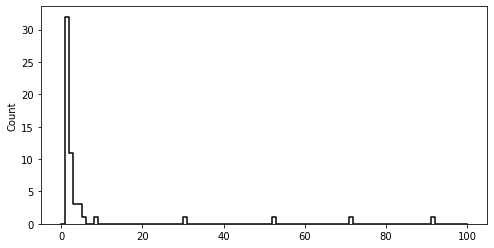

In [36]:
## Building a loop through leaf names that can sort taxonomic groups. This is a generalized search that should identify species groupings for 
divergenceLimit = 240.0;

taxoGroups = []
taxonList = []
for taxon in phyloTree.taxon_namespace:
    taxonList.append(taxon.label)
#treeClone = phyloTree.clone(depth=1)
for taxon in phyloTree.taxon_namespace:
    while taxon.label in taxonList:
        taxoGroups.append([taxon.label])
        for taxonCompare in phyloTree.taxon_namespace:
            if (pdc(taxon, taxonCompare) <= divergenceLimit) and (taxonCompare != taxon):
                taxoGroups[-1].append(taxonCompare.label)
                taxonList.remove(taxonCompare.label)
        taxonList.remove(taxon.label)

print("Total number of monophyletic groups:\t", len(taxoGroups))

##Hist of group sizes
groupSize = []
for taxoGroup in taxoGroups:
    groupSize.append(len(taxoGroup))
binList = list(range(int(math.ceil(1.1*max(groupSize)))))
print("Number of species in largest monophyletic group:\t", max(groupSize))
print(groupSize)
fig1 = figure(figsize=(8,4))
ax1 = sns.histplot(groupSize, kde=False, bins=binList, stat='count', element='step', fill=False, color='black');
#ax1 = sns.distplot(groupSize, kde=False, bins=binList, hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1});
#plt.ylim(0, 50)
#ax2 = sns.swarmplot(groupSize);
#savefig(os.path.join(figure_dir, 'pheromone-phyloGroups_species-grouping-density_210718.pdf'), dpi=300, transparent=True, bbox_inches='tight')

with open(os.path.join(tree_dir, "taxonGroups_240max-dist.csv"), 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(taxoGroups)

In [26]:
###Phylogenetic groups that correspond to infered time-horizon of lipidated pheromone conservation. 
print(*[group for group in taxoGroups if len(group)>=1], sep = "\n")

['yHMPu5000041678 Debaryomyces prosopidis', 'yHMPu5000041829 Debaryomyces fabryi', 'yHMPu5000041824 Debaryomyces subglobosus', 'Debaryomyces hansenii', 'yHMPu5000041693 Debaryomyces nepalensis', 'yHMPu5000041713 Debaryomyces maramus', 'Millerozyma acaciae', 'yHMPu5000035296 Priceomyces carsonii', 'yHMPu5000035297 Priceomyces castillae', 'Priceomyces haplophilus', 'yHMPu5000034606 Priceomyces medius', 'Scheffersomyces lignosus', 'Scheffersomyces stipitis', 'Spathaspora passalidarum', 'Spathaspora girioi', 'Spathaspora arborariae', 'Spathaspora gorwiae', 'Spathaspora hagerdaliae', 'Candida sojae', 'Candida tropicalis', 'Candida albicans', 'Candida dubliniensis', 'yHMPu5000034990 Candida corydali', 'Lodderomyces elongisporus', 'Candida orthopsilosis', 'Candida parapsilosis', 'yHMPu5000034654 Aciculoconidium aculeatum', 'yHMPu5000034665 Kodamaea laetipori', 'yHMPu5000034648 Candida restingae', 'yHMPu5000035677 Kodamaea ohmeri', 'yHMPu5000035022 Candida emberorum', 'yHMPu5000035018 Candida 

In [27]:
#print(phyloTree.taxon_namespace)
test = [];
taxonList = phyloTree.taxon_namespace;
for taxon in phyloTree.taxon_namespace:
    if taxon in taxonList:
        #print(taxon.label)
        for taxonCompare in phyloTree.taxon_namespace:
            test.append(pdc(taxon, taxonCompare))
print(len(test))

110224


#### Code to print out Phylo-groups within a certain evolutionary distance threshold where the pheromones are expected to be conserved
Work started on 20200204 at 1545hrs. I am just going to publish groups that have 2 or more species within the group.

In [28]:
##Making sure the species names have underscores instead of white space analogous to what is listed in the dictionary "332taxa_index.txt" (and "332genomes_Shen2017.csv").
iterCount = 0;
for iterCount in range(len(taxoGroups)):
    #print(len(taxoGroups[iterCount]))
    iterCount1 = 0;
    for iterCount1 in range(len(taxoGroups[iterCount])):
        taxoGroups[iterCount][iterCount1] = taxoGroups[iterCount][iterCount1].replace(" ", "_")
    #print(taxoGroups[iterCount])
#print("Done modifying species names in ", len(taxoGroups), "taxon groups. Good Luck!")

In [29]:
##I need to import the csv from 332taxa_index into a dictionary with the columns {"old_speceis_names" : "original_genome_id"}. I think there is a direct way to do this.
with open(os.path.join(tree_dir, "332genomes_Shen2017.csv"), mode='r') as infile:
    reader = csv.reader(infile)
    fileDict = {rows[1]:rows[0] for rows in reader}

#print(len(fileDict))
#print(taxoGroups[0][0], fileDict[taxoGroups[0][0]])

##I am going to print out the species lits in the Phylo groups of Fungi and I hope to pool these species together to judge the copy number in these groups.
if not(os.path.isdir(os.path.join(tree_dir, "PhyloGroups_pheromones"))):
    os.mkdir(os.path.join(tree_dir, "PhyloGroups_pheromones"))

groupCount = 0
for groupCount in range(len(taxoGroups)):
    if len(taxoGroups[groupCount]) >= 2:
        outputHandle = open(os.path.join(tree_dir, "PhyloGroups_pheromones", "phyloGroup_"+str(groupCount+1)+".txt"), "w")
        for species in taxoGroups[groupCount]:
            #print(fileDict[species])
            outputHandle.write(fileDict[species]+".fas.caax.asn"+"\n")
        outputHandle.close()

#### Code-chunk to identify time-horizon of mating regulatory motifs in the yeast lineage

Total number of monophyletic groups:	 79
Number of species in largest monophyletic group:	 47


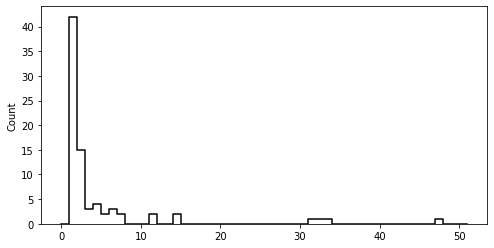

In [38]:
## Building a loop through leaf names that can sort taxonomic groups. This is a generalized search that should identify species groupings for 
divergenceLimit = 180.0;

taxonGroups_regulation = []
taxonList_regulation = []
for taxon in phyloTree.taxon_namespace:
    taxonList_regulation.append(taxon.label)
#treeClone = phyloTree.clone(depth=1)
for taxon in phyloTree.taxon_namespace:
    while taxon.label in taxonList_regulation:
        taxonGroups_regulation.append([taxon.label])
        for taxonCompare in phyloTree.taxon_namespace:
            if (pdc(taxon, taxonCompare) <= divergenceLimit) and (taxonCompare != taxon):
                taxonGroups_regulation[-1].append(taxonCompare.label)
                taxonList_regulation.remove(taxonCompare.label)
        taxonList_regulation.remove(taxon.label)

print("Total number of monophyletic groups:\t", len(taxonGroups_regulation))

##Hist of group sizes
groupSize = []
for taxonGroup_regulation in taxonGroups_regulation:
    groupSize.append(len(taxonGroup_regulation))
binList = list(range(int(math.ceil(1.1*max(groupSize)))))
print("Number of species in largest monophyletic group:\t", max(groupSize))
fig1 = figure(figsize=(8,4))
ax1 = sns.histplot(groupSize, kde=False, bins=binList, stat='count', element='step', color='black', fill=False);
#plt.ylim(0, 50)
#ax2 = sns.swarmplot(groupSize);
#savefig(os.path.join(figure_dir, 'mating-regulation-phyloGroups_species-grouping-density_210718.pdf'), dpi=300, transparent=True, bbox_inches='tight')

with open(os.path.join(tree_dir, "taxonGroups_180max-dist_mating-regulation.csv"), 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(taxoGroups)

In [31]:
#print(phyloTree.taxon_namespace)
test = [];
taxonList_regulation = phyloTree.taxon_namespace;
for taxon in phyloTree.taxon_namespace:
    if taxon in taxonList_regulation:
        #print(taxon.label)
        for taxonCompare in phyloTree.taxon_namespace:
            test.append(pdc(taxon, taxonCompare))
print(len(test))

110224


In [32]:
print(*[group for group in taxonGroups_regulation if len(group)>=1], sep = "\n")

['yHMPu5000041678 Debaryomyces prosopidis', 'yHMPu5000041829 Debaryomyces fabryi', 'yHMPu5000041824 Debaryomyces subglobosus', 'Debaryomyces hansenii', 'yHMPu5000041693 Debaryomyces nepalensis', 'yHMPu5000041713 Debaryomyces maramus', 'Millerozyma acaciae']
['yHMPu5000035296 Priceomyces carsonii', 'yHMPu5000035297 Priceomyces castillae', 'Priceomyces haplophilus', 'yHMPu5000034606 Priceomyces medius', 'Scheffersomyces lignosus', 'Scheffersomyces stipitis', 'Spathaspora passalidarum', 'Spathaspora girioi', 'Spathaspora arborariae', 'Spathaspora gorwiae', 'Spathaspora hagerdaliae', 'Candida sojae', 'Candida tropicalis', 'Candida albicans', 'Candida dubliniensis', 'yHMPu5000034990 Candida corydali', 'Lodderomyces elongisporus', 'Candida orthopsilosis', 'Candida parapsilosis', 'yHMPu5000034654 Aciculoconidium aculeatum', 'yHMPu5000034665 Kodamaea laetipori', 'yHMPu5000034648 Candida restingae', 'yHMPu5000035677 Kodamaea ohmeri', 'yHMPu5000035022 Candida emberorum', 'yHMPu5000035018 Candida

In [33]:
##Making sure the species names have underscores instead of white space analogous to what is listed in the dictionary "332taxa_index.txt" (and "332genomes_Shen2017.csv").
iterCount = 0;
for iterCount in range(len(taxonGroups_regulation)):
    #print(len(taxoGroups_regulation[iterCount]))
    iterCount1 = 0;
    for iterCount1 in range(len(taxonGroups_regulation[iterCount])):
        taxonGroups_regulation[iterCount][iterCount1] = taxonGroups_regulation[iterCount][iterCount1].replace(" ", "_")
    #print(taxonGroups_regulation[iterCount])
print("Done modifying species names in ", len(taxonGroups_regulation), "taxon groups. Good Luck!")

Done modifying species names in  79 taxon groups. Good Luck!


In [35]:
##I need to import the csv from 332taxa_index into a dictionary with the columns {"old_speceis_names" : "original_genome_id"}. I think there is a direct way to do this.
with open(os.path.join(tree_dir, "332genomes_Shen2017.csv"), mode='r') as infile:
    reader = csv.reader(infile)
    fileDict = {rows[1]:rows[0] for rows in reader}

#print(len(fileDict))
#print(taxonGroups_regulation[0][0])
#print(taxonGroups_regulation[0][0], fileDict[taxonGroups_regulation[0][0]])

##I am going to print out the species lits in the Phylo groups of Fungi and I hope to pool these species together to judge the copy number in these groups.
if not(os.path.isdir(os.path.join(tree_dir, "PhyloGroups_regulation"))):
    os.mkdir(os.path.join(tree_dir, "PhyloGroups_regulation"))

groupCount = 0
for groupCount in range(len(taxonGroups_regulation)):
    if len(taxonGroups_regulation[groupCount]) >= 2:
        outputHandle = open(os.path.join(tree_dir, "PhyloGroups_regulation", "phyloGroup_"+str(groupCount+1)+".txt"), "w")
        for species in taxonGroups_regulation[groupCount]:
            #print(fileDict[species])
            outputHandle.write("promoters_0_"+fileDict[species]+".fasta"+"\n")
        outputHandle.close()

In [37]:
##I need to import the csv from 332taxa_index into a dictionary with the columns {"old_speceis_names" : "original_genome_id"}. I think there is a direct way to do this.
with open(os.path.join(tree_dir, "332genomes_Shen2017.csv"), mode='r') as infile:
    reader = csv.reader(infile)
    fileDict = {rows[1]:rows[0] for rows in reader}

#print(len(fileDict))
#print(taxonGroups_regulation[0][0])
#print(taxonGroups_regulation[0][0], fileDict[taxonGroups_regulation[0][0]])

##I am going to print out the species lits in the Phylo groups of Fungi and I hope to pool these species together to judge the copy number in these groups.
if not(os.path.isdir(os.path.join(tree_dir, "PhyloGroups_candidate_regulation"))):
    os.mkdir(os.path.join(tree_dir, "PhyloGroups_candidate_regulation"))

groupCount = 0
for groupCount in range(len(taxonGroups_regulation)):
    if len(taxonGroups_regulation[groupCount]) >= 2:
        outputHandle = open(os.path.join(tree_dir, "PhyloGroups_candidate_regulation", "phyloGroup_"+str(groupCount+1)+".txt"), "w")
        for species in taxonGroups_regulation[groupCount]:
            #print(fileDict[species])
            outputHandle.write(fileDict[species]+".fas.caax.asn.promoters"+"\n")
        outputHandle.close()

## Code to sort all CAAX-Asn candidates for unique loci
>Date started 191211, 1500 IST  

This is a small code block to accept a fasta list of all the candidates I identify from a genome and then try to get a unique list for finding multiple copies of a candidate at different genome loci (obviously).

In [25]:
##Importing the FASTA file, this won't be used when I add this to the python codebase for functionality. Remember to run the first two blocks for all library imports.
inputFile = "Yarli1_AssemblyScaffolds-put-v2p3_180508.fasta"
fileHandle = open(data_dir+inputFile, "r")
candidates = list(SeqIO.parse(fileHandle, "fasta"))
fileHandle.close()

print(candidates[0].id)
#print(candidates[0].id.split("||")[1].split("[")[3].split("-")[:])
print("There are %i candidates" % len(candidates))

Yali0A_1||[forward][1][45693-45756-45768][Translate:MSNLTSHRVGVRSTPRRAISSCSVS*]
There are 399 candidates


#### Algorthm for stack search
- The simplest approach is to brute-force the search and basically compare the current candidate to with all others to see if there is something that shares the chromID, direction and CAAX-STOP positions while having a higher candidate number.
- Another option is to just invert the stack and pull candidates one after another and since the first candidate from the back would be the largest ORF at any given CAAX-STOP, then all I would have to do is compare the current ID to the last in the new list I am making, and if it is the same keep moving, else append to the list I am making.

In [28]:
##Function to parse candidates and eliminate those that share a CAAX tag (retain the largest ORF among those that share CAAX-STOP). 
##Trying the cheat version with a reversed iterator.
uniqueCandidates = []
skipCount = 0
for candidate in reversed(candidates):
    #print(candidate.id)
    if (uniqueCandidates != []):
        if (candidate.id.split("||")[0] == uniqueCandidates[-1].id.split("||")[0]) and (candidate.id.split("||")[1].split("[")[1] == uniqueCandidates[-1].id.split("||")[1].split("[")[1]):
            if candidate.id.split("||")[1].split("[")[3].split("-")[2] == uniqueCandidates[-1].id.split("||")[1].split("[")[3].split("-")[2]:
                skipCount += 1
            else:
                uniqueCandidates.append(candidate)
        else:
            uniqueCandidates.append(candidate)
    else:
        uniqueCandidates.append(candidate)

print("Skipped %i candidates" % skipCount)
uniqueCandidates.reverse()
print(len(uniqueCandidates))

##printing output.
outputHandle = open(data_dir+inputFile.split(".f")[0]+"_unique.fasta", "w")
for candidate in uniqueCandidates:
    outputHandle.write(">"+str(candidate.id)+"\n"+str(candidate.seq)+"\n")
outputHandle.close()

Skipped 147 candidates
252


In [ ]:
for candidate in uniqueCandidates:
    print(candidate.id)